# Logistic Regression

##### Predicting the outcome of a shot given its features

---

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

By now, you should be familiar with all of these libraries

---

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
                
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

The `parse_data` function has been adjusted such that only shots are collected, and a bunch of new attributes are collected, including:
- `x` - the x-coordinate of the shot
    - ranges from `0 to 120`
- `y` - the y-coordinate of the shot
    - ranges from `0 to 80`
- `head` - if the shot was attempted with the head
- `phase` - what phase of play did the shot come from
- `outcome` - did the shot result in a goal
- `statsbomb_xg` - for comparison purposes at the end of the notebook

---

In [4]:
competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|██████████| 64/64 [00:13<00:00,  4.80it/s]


In [5]:
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

The `distance_to_goal` function takes an x/y pair (e.g. `[x, y]`), and calculates how far from the center of the goal that location is.

---

In [6]:
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

The `goal_angle` function (which returns radians) generates the angle of the goalmouth that is available to the shooter at the time of the shot.

It also depends some vector mathematics, but essentially we return one of the interior angles between a triangle bounded by the origin and the coordinates of each goal post.

---

In [7]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

These operations add new columns (`distance_to_goal` and `goal_angle`) to every row in the `pandas` DataFrame using a technique called broadcasting, and it's efficent when dealing with very large amounts of data.

It's worth digging into `lambda` functions as well. They're essentially anonymous functions that you can declare dynamically.

In general, you should avoid looping over `pandas` DataFrames in favor of this sort of approach.

---

In [8]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

This `pandas` operation filters the DataFrame by removing all rows that have `Free Kick` or `Penalty` as it's designated `phase`.

We remove these samples before training because they will skew our results as most samples are taken from open play.

---

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

This time, we import `LogisticRegression` from `sklearn.linear_model` and create an object of it.

---

In [10]:
features = shots[['distance_to_goal', 'goal_angle', 'head']]
labels = shots['outcome']

fit = model.fit(features, labels)

We slice the `shots` DataFrame into two new DataFrames that represent the model **features** (the attributes we think are important) and the model **labels** (what we're trying to predict).

Then we fit the model using `.fit(features, labels)`

You can obtain the residuals of this model by inspecting the `fit` variable.

> **Note**: In a real-word setting, we would want to normalize some of our continuous features (like `distance_to_goal` and `goal_angle`) that are not normally distributed. The model that we're fitting to the data applies linear weights to each variable, meaning that each feature can only have a linear effect on the outcome. This is bad because we know there is a small difference between a shot 30 vs. 35 meters from goal, and a big difference between a shot 5 vs. 10 yards from meters (despite there being just a 5 meter difference between both examples). The properties of the model, as currently configured, can't make this sort of distinction.
>
> `sklearn` has a nice [`preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) package that can handle some of this for you.

---

In [11]:
predictions = model.predict_proba(features)[:, 1]

The `model.predict_proba()` method calculates label predictions of the list of samples that you feed into it.

> *Note*: In this example, we're feeding the original list of samples that we trained on, which is generally a bad thing, but this is just a toy model.
>
> In a real-world setting, we would want to split our samples into a training and a validation data sets to help us avoid over-fitting.

---

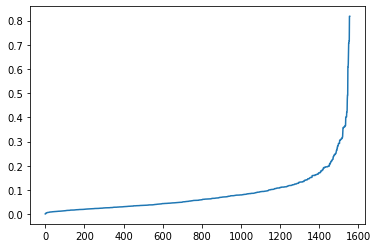

In [12]:
plt.plot(sorted(predictions))
plt.show()

We sort the predictions, and plot them.

As expected, we predict that most shots are quite unlikely to result in a goal, with only a narrow range of opportunities having a goal probability of greater than `0.5 or 50%`.

---

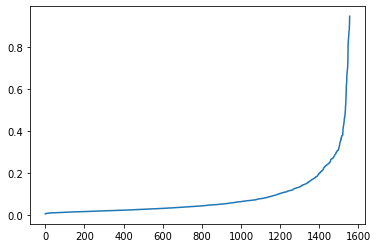

In [13]:
plt.plot(sorted(shots['statsbomb_xg']))
plt.show()

For the sake of comparison, this looks quite a lot like the distribution of StatsBomb's goal expectation estimates. It's possible to make a pretty reasonable goal probability model with pretty basic features and minimal samples size.

---

Devin Pleuler 2020